In [1]:
import lib ## my module set

import os
import torch
import torchvision
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import random

from tqdm import tqdm
from sklearn.manifold import TSNE
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.models import efficientnet_b0, mobilenet_v2, shufflenet_v2_x1_5
from sklearn.metrics import silhouette_score, silhouette_samples



%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "5"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # 멀티 GPU를 사용하는 경우
np.random.seed(42)
random.seed(42)
# torch.backends.cudnn.deterministic = True ## 속도가 느려질 수 있음
# torch.backends.cudnn.benchmark = False

plt.rcParams['font.family'] = 'Liberation Serif'

In [2]:
train = pd.read_csv("./train_v2.csv")
valid = pd.read_csv("./valid_v2.csv")
test = pd.read_csv("./test_v2.csv")

In [3]:
train_dataset = lib.CustomDataset(train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory= True, num_workers = 8) 

valid_dataset = lib.CustomDataset(valid, train_test= False)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = True, pin_memory= True, num_workers = 8)

test_dataset = lib.CustomDataset(test, train_test = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, pin_memory= True, num_workers = 8)

In [4]:
class MyNeural(nn.Module):
    def __init__(self, model, freeze_ratio = 0.7):
        super(MyNeural, self).__init__()

        self.mother = model

        self.mother.fc = nn.Linear(1024, 256, bias = True)

        
        self.classifier = nn.Sequential(
            nn.SiLU(inplace = True),
            nn.Dropout(0.2, inplace = True),
            nn.Linear(256, 64, bias = True),
            nn.SiLU(inplace = True),
            nn.Dropout(0.2, inplace = True),
            nn.Linear(64, 4, bias = True)
        )

    
    def forward(self, x):
        embedding = self.mother(x)
         
        x = self.classifier(embedding)

        return (embedding, x)

Shufflenet = shufflenet_v2_x1_5(weights = 'IMAGENET1K_V1')

Shufflenet = MyNeural(Shufflenet, freeze_ratio = 0).to(device)

In [7]:
## 학습을 위한 최적화, 함수, Miner 설정

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(Shufflenet.parameters(), lr=1e-4)

# training, Deep Metric Learning

patience = 0
Epochs = 100
best_loss = 999999.0

for epoch in range(Epochs):
    train_loss, train_correct = lib.classifier_train(train_loader, Shufflenet, loss_fn, optimizer)
    valid_loss, valid_correct = lib.classifier_validation(valid_loader, Shufflenet, loss_fn)
    
    print(f"Epoch {epoch} : Train Loss = {train_loss:.4f}, Train Correct: {train_correct} Valid Loss = {valid_loss:.4f}, Valid Correct = {valid_correct}")
    
    if best_loss > valid_loss:
        best_loss = valid_loss
        patience = 0
        print(f'Epoch {epoch} Model saved ')
        torch.save({
                'model' : Shufflenet.state_dict(),
                'optimizer' : optimizer.state_dict()}, '../model_weight/Classifier/Shufflenet.pth')
    else:
        patience += 1
        if patience == 10:
            print('early stopping')
            break
        

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 32/37 [00:10<00:01,  3.08it/s]


KeyboardInterrupt: 

In [5]:
checkpoint = torch.load('../model_weight/Classifier/Shufflenet.pth')

Shufflenet.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [6]:
total_loader_v = DataLoader(valid_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)
total_loader_t = DataLoader(test_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)

test_loss, correction = lib.classifier_validation(total_loader_v, Shufflenet, loss_fn)
print(correction)

NameError: name 'loss_fn' is not defined

In [7]:



pred_acc = []
real_acc = []

embeddings = []

with torch.no_grad():
    Shufflenet.eval()
    for data, label in tqdm(total_loader_t, desc = 'total_loader_v'):
        data = data.to(device)
        embedding, pred = Shufflenet(data)
        
        embeddings.append(embedding)
        
        pred_acc.append(pred.argmax(1).item())
        real_acc.append(label.item())

embeddings = torch.stack(embeddings, dim = 1).squeeze()

    

total_loader_v: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:02<00:00, 75.83it/s]


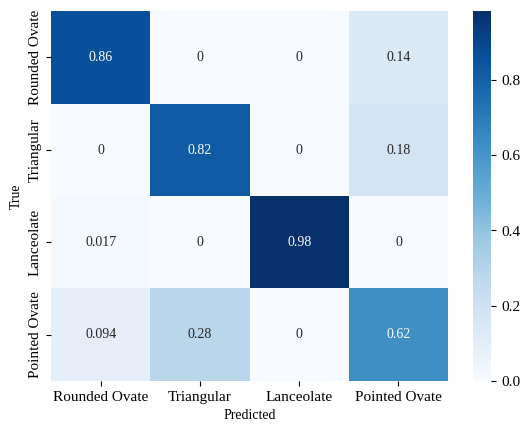

In [8]:
plt.rc('xtick', labelsize=11)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=11) 


cm = confusion_matrix(real_acc, pred_acc, normalize = 'true')
cm = pd.DataFrame(cm , columns = ['Rounded Ovate', 'Triangular', 'Lanceolate', 'Pointed Ovate'],index = ['Rounded Ovate', 'Triangular', 'Lanceolate', 'Pointed Ovate'])
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

0.3741721212863922

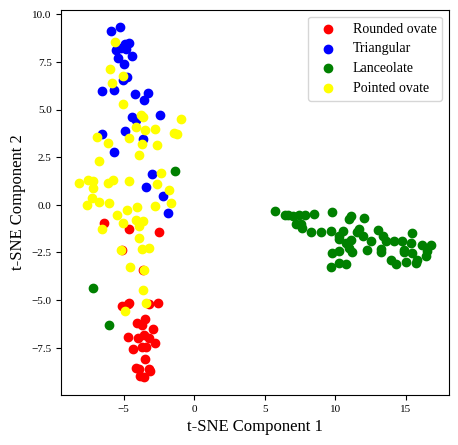

In [9]:

plt.figure(figsize=(5, 5))

plt.rc('xtick', labelsize=8)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=8)  # y축 눈금 폰트 크기
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10) 


tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(embeddings.detach().cpu())

df_tsne = pd.DataFrame(data = X_tsne)
df_tsne['label']= real_acc
df_tsne

plt.scatter(df_tsne[df_tsne['label'] == 0][0], df_tsne[df_tsne['label'] == 0][1], label = 'Rounded ovate',  c= 'red')
plt.scatter(df_tsne[df_tsne['label'] == 1][0], df_tsne[df_tsne['label'] == 1][1], label = 'Triangular', c= 'blue')
plt.scatter(df_tsne[df_tsne['label'] == 2][0], df_tsne[df_tsne['label'] == 2][1], label = 'Lanceolate', c= 'green')
plt.scatter(df_tsne[df_tsne['label'] == 3][0], df_tsne[df_tsne['label'] == 3][1], label = 'Pointed ovate',  c= 'yellow')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

score = silhouette_score(X_tsne, real_acc)
score

In [10]:
score_samples = silhouette_samples(df_tsne[[0, 1]], df_tsne['label'])
df_tsne['sil_coeffi'] = score_samples
df_tsne.groupby('label')['sil_coeffi'].mean()

label
0    0.567708
1    0.313697
2    0.642188
3    0.006924
Name: sil_coeffi, dtype: float32